# Reproducibility study on: *Fairness without Demographics through Adversarially Reweighted Learning*
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TomFrederik/fact-ai/blob/main/results.ipynb)

This notebook can reproduce all the figures and tables from our report. You can run it from top to bottom without interventions or you can use it more interactively and tweak things along the way.

## Setup
We first need to import some modules and set up a reasonable default config. You can skip this section, all settings can be adjusted later on.

In [1]:
from argparse import Namespace
import itertools
import json
import statistics
import os
from collections import defaultdict
import numpy as np
import torch
import pandas as pd
from main import main

Cuda available? False


In [2]:
args = Namespace(
    model='ARL',
    prim_hidden=[64, 32],
    adv_hidden=[],
    eta=0.5,
    k=2.0,
    pretrained=False,
    adv_input=['X', 'Y'],
    batch_size=256,
    train_steps=5000,
    prim_lr=0.1,
    seed=0,
    seed_run=False,
    seed_run_version=0,
    pretrain_steps=250,
    opt='Adagrad',
    # This directory will be used to save logs and checkpoint from your own runs.
    # Don't change it to final_runs unless you want to overwrite our results (which isn't
    # necessary, you can instead adjust which results are used in the notebook)
    log_dir='training_logs',
    # progress bar won't work in notebook
    p_bar=False,
    num_folds=5,
    grid_search=False,
    eval_batch_size=512,
    tf_mode=True,
    dataset='Adult',
    num_workers=0,
    disable_warnings=True,
    sensitive_label=False,
    num_cpus=1,
    num_gpus=0.25
)
args.dataset_type = 'image' if args.dataset in ['FairFace', 'FairFace_reduced', 'EMNIST'] else 'tabular'
args.working_dir = os.getcwd()

In [3]:
all_models = ['baseline', 'DRO', 'ARL', 'IPW']
all_datasets = ['Adult', 'LSAC', 'COMPAS']

## Single training run
We begin by training end evaluating a single model to show how our interface works in a simple setting. You can skip this section if you want to immediately reproduce our results.

You can change hyperparameters by adjusting attributes of the `args` object:

In [6]:
# args.batch_size =

# learning rate:
# args.prim_lr =

# Uncomment to use PyTorch rather than TF defaults for initialization and optimizer
# args.tf_mode = False

# List of the hidden dimensions for the learner and adversary
# args.prim_hidden = []
# args.adv_hidden = []

# Input that the adversary has access to. X are features, Y labels and S protected group memberships
# args.adv_input = ['X', 'Y', 'S']

# maximum number of training steps
# args.train_steps = 1000

Dataset and model are also chosen using the `args` object:

In [7]:
# choices are 'ARL', 'baseline', 'DRO', 'IPW' and 'baseline_cnn'
args.model = 'ARL'

# choices are 'Adult', 'LSAC', 'COMPAS', 'FairFace', 'FairFace_reduced', 'EMNIST'
args.dataset = 'Adult'

You can probably leave the remaining settings on their default values, but the documentation of the `main.py` script contains a complete list of attributes that can be set via the `args` object:

In [17]:
!python main.py --help

Cuda available? False
usage: main.py [-h] --model {baseline,ARL,DRO,IPW,baseline_cnn}
               [--prim_hidden [PRIM_HIDDEN [PRIM_HIDDEN ...]]]
               [--adv_hidden [ADV_HIDDEN [ADV_HIDDEN ...]]] [--eta ETA]
               [--k K] [--pretrained] [--adv_input ADV_INPUT [ADV_INPUT ...]]
               [--batch_size BATCH_SIZE] [--train_steps TRAIN_STEPS]
               [--prim_lr PRIM_LR] [--seed SEED] [--seed_run]
               [--seed_run_version SEED_RUN_VERSION]
               [--pretrain_steps PRETRAIN_STEPS] [--opt {Adagrad,Adam}]
               [--log_dir LOG_DIR] [--p_bar] [--num_folds NUM_FOLDS]
               [--no_grid_search] [--eval_batch_size EVAL_BATCH_SIZE]
               [--tf_mode] --dataset
               {Adult,LSAC,COMPAS,FairFace,FairFace_reduced,EMNIST}
               [--num_workers NUM_WORKERS] [--disable_warnings]
               [--sensitive_label] [--num_cpus NUM_CPUS] [--num_gpus NUM_GPUS]

optional arguments:
  -h, --help            show this hel

The `main` function does the following:
1. Load the dataset
2. Randomly split off 10% of the training set as a validation set
3. Train the model, using the validation set for early stopping
4. Load the best model (according to validation performance)
5. Evaluate the performance of that model on the test set

It prints out the final test performance and also saves it to disk, as well as checkpoints and tensorboard logs. Running it for a single model and dataset should take a few minutes at most.

It can also perform a grid search to find the optimal learning rate and batch size, but we won't use that until later.

In [11]:
main(args)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
/home/erik/.miniconda3/envs/fact-ai/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name      | Type              | Params
------------------------------------------------
0 | learner   | Learner           | 8.6 K 
1 | adversary | Adversary         | 103   
2 | loss_fct  | BCEWithLogitsLoss | 0     
------------------------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params


creating dir ./training_logs/ARL_Adult_0.1_256_5000


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

/home/erik/.miniconda3/envs/fact-ai/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

/home/erik/.miniconda3/envs/fact-ai/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: training_step returned None if it was on purpose, ignore this warning...
  warnings.warn(*args, **kwargs)


time to fit was 75.60707354545593
Results = {'min_auc': 0.8681613206863403, 'macro_avg_auc': 0.9054139405488968, 'micro_avg_auc': 0.8955512046813965, 'minority_auc': 0.9349005222320557, 'accuracy': 0.8387691378593445}


## Runs for all models and datasets
To recreate the tables from our report, we need to train every model on each of the datasets. We also need to do several runs with different seeds for each combination. This may take a bit longer (on the order of 1h), so you can also skip directly to the next section and create the tables and figures based on our results.

We begin by loading the optimal hyperparameters that we determined using grid search. If you want to do your own grid search, see the corresponding section below first.

In [22]:
with open('optimal_hparams.json') as f:
    optimal_hparams = json.load(f)

The hyperparameter settings are simply a dictionary:

In [23]:
print(json.dumps(optimal_hparams, indent=4))

{
    "Adult": {
        "baseline": {
            "batch_size": 512,
            "prim_lr": 2
        },
        "DRO": {
            "batch_size": 128,
            "prim_lr": 1,
            "eta": 0.5
        },
        "ARL": {
            "batch_size": 128,
            "prim_lr": 0.1
        }
    },
    "LSAC": {
        "baseline": {
            "batch_size": 64,
            "prim_lr": 0.1
        },
        "DRO": {
            "batch_size": 128,
            "prim_lr": 1,
            "eta": 0.6
        },
        "ARL": {
            "batch_size": 64,
            "prim_lr": 0.1
        }
    },
    "COMPAS": {
        "baseline": {
            "batch_size": 256,
            "prim_lr": 0.1
        },
        "DRO": {
            "batch_size": 256,
            "prim_lr": 1,
            "eta": 0.6
        },
        "ARL": {
            "batch_size": 256,
            "prim_lr": 0.1
        }
    }
}


If you want to use your own hyperparameters instead, you can therefore just change or overwrite the `optimal_hparams` variable. You are also not limited to setting learning rate and batch size; you can set any of the `args` attributes individually for each model/dataset combination. Any values that are not set use the defaults we specified above.

In [28]:
# You can adjust here which models and datasets you want to run
models = ['baseline', 'DRO', 'ARL', 'IPW(S)', 'IPW(S+Y)']
datasets = ['Adult', 'LSAC', 'COMPAS']

In [10]:
def run_models(seed):
    result_dict = {}
    for dataset, model in itertools.product(datasets, models):
        # don't overwrite the defaults:
        temp_args = Namespace(**vars(args))
        if model == 'IPW(S)':
            temp_args.model = 'IPW'
            temp_args.sensitive_label = False
        elif model == 'IPW(S+Y)':
            temp_args.model = 'IPW'
            temp_args.sensitive_label = True
        else:
            temp_args.model = model
        temp_args.dataset = dataset
        temp_args.seed = seed
        # set the optimal hyperparameters:
        for k, v in optimal_hparams[dataset][model]:
            setattr(args, k, v)

        # train and evaluate the model:
        result_dict[(dataset, model)] = main(args)
    return result_dict

In [12]:
all_dicts = []
for seed in range(10):
    all_dicts.append(run_models(seed))

our_results = {
    k: {
        'mean': statistics.mean(result_dict[k] for result_dict in all_dicts),
        'std': statistics.std(result_dict[k] for result_dict in all_dicts)
    } for k in itertools.product(datasets, models)
}

NameError: name 'optimal_hparams' is not defined

## Creating the performance tables

We define a function that loads our own results:

In [6]:
from analysis_utils import *

If you didn't run train your own models in the previous section, then remove the comment in the following line and run it, in order to load our results:

In [18]:
our_results = load_result_dict('final_logs', datasets, models, get_our_path)

The result dictionary contains the mean and standard deviation across runs, for each metric and each dataset/method combination we used:

In [19]:
our_results

{('Adult',
  'ARL'): {'min_auc': {'mean': 0.8839888334274292,
   'std': 0.0009290685557899277}, 'macro_avg_auc': {'mean': 0.9177511766552925,
   'std': 0.0007697829337825584}, 'micro_avg_auc': {'mean': 0.909021383523941,
   'std': 0.0006983387894980422}, 'minority_auc': {'mean': 0.9392572224140168,
   'std': 0.0031013138435674096}, 'accuracy': {'mean': 0.8504084527492524,
   'std': 0.0027642594178873365}},
 ('Adult',
  'DRO'): {'min_auc': {'mean': 0.885297292470932,
   'std': 0.0006518614005294807}, 'macro_avg_auc': {'mean': 0.918700386583805,
   'std': 0.001815989101837644}, 'micro_avg_auc': {'mean': 0.9101847589015961,
   'std': 0.0007322508613241217}, 'minority_auc': {'mean': 0.9414238631725311,
   'std': 0.0059271811311176065}, 'accuracy': {'mean': 0.8574227571487427,
   'std': 0.0015485177592630156}},
 ('Adult',
  'baseline'): {'min_auc': {'mean': 0.8841554284095764,
   'std': 0.001854611751477643}, 'macro_avg_auc': {'mean': 0.9192625850439071,
   'std': 0.0011282166339539464}, 'm

We also provide helper tools to pretty print these results as Markdown tables:

In [23]:
from IPython.display import display, Markdown

keys = ['micro_avg_auc', 'macro_avg_auc', 'min_auc', 'minority_auc', 'accuracy']
bold_dict = is_max(our_results, keys)
header = """
|Dataset|Method|Micro-avg AUC|Macro-avg AUC|Min AUC|Minority AUC|Accuracy|
|---|---|---|---|---|---|---|
"""
table = create_table(our_results, keys, bold_dict, create_markdown_line_with_std)
display(Markdown(header + table))


|Dataset|Method|Micro-avg AUC|Macro-avg AUC|Min AUC|Minority AUC|Accuracy|
|---|---|---|---|---|---|---|
|Adult | ARL | 0.9090 +- 0.0007 | 0.9178 +- 0.0008 | 0.8840 +- 0.0009 | 0.9393 +- 0.0031 | 0.8504 +- 0.0028
|Adult | DRO | 0.9102 +- 0.0007 | 0.9187 +- 0.0018 | 0.8853 +- 0.0007 | 0.9414 +- 0.0059 | **0.8574 +- 0.0015**
|Adult | baseline | 0.9093 +- 0.0016 | 0.9193 +- 0.0011 | 0.8842 +- 0.0019 | 0.9440 +- 0.0040 | 0.8498 +- 0.0070
|Adult | IPW(S) | 0.9085 +- 0.0004 | 0.9179 +- 0.0007 | 0.8826 +- 0.0005 | 0.9434 +- 0.0018 | 0.8557 +- 0.0010
|Adult | IPW(S+Y) | **0.9110 +- 0.0009** | **0.9209 +- 0.0020** | **0.8859 +- 0.0010** | **0.9465 +- 0.0047** | 0.7428 +- 0.0160
|LSAC | ARL | 0.8122 +- 0.0063 | 0.8063 +- 0.0091 | 0.7870 +- 0.0066 | 0.8264 +- 0.0199 | 0.7501 +- 0.0290
|LSAC | DRO | 0.8242 +- 0.0051 | 0.8217 +- 0.0053 | 0.8024 +- 0.0055 | 0.8361 +- 0.0088 | 0.8570 +- 0.0057
|LSAC | baseline | 0.8309 +- 0.0061 | 0.8263 +- 0.0063 | 0.8096 +- 0.0073 | 0.8371 +- 0.0087 | **0.8604 +- 0.0047**
|LSAC | IPW(S) | 0.8147 +- 0.0066 | 0.8088 +- 0.0056 | 0.7933 +- 0.0089 | 0.8162 +- 0.0090 | 0.8483 +- 0.0033
|LSAC | IPW(S+Y) | **0.8371 +- 0.0038** | **0.8302 +- 0.0030** | **0.8150 +- 0.0054** | **0.8374 +- 0.0072** | 0.8352 +- 0.0108
|COMPAS | ARL | **0.7364 +- 0.0026** | **0.7347 +- 0.0032** | **0.7008 +- 0.0023** | 0.7481 +- 0.0080 | **0.6756 +- 0.0091**
|COMPAS | DRO | 0.7361 +- 0.0030 | 0.7347 +- 0.0032 | 0.6997 +- 0.0035 | **0.7533 +- 0.0044** | 0.6688 +- 0.0071
|COMPAS | baseline | 0.7357 +- 0.0025 | 0.7340 +- 0.0027 | 0.6995 +- 0.0029 | 0.7475 +- 0.0024 | 0.6735 +- 0.0057
|COMPAS | IPW(S) | 0.7300 +- 0.0040 | 0.7294 +- 0.0058 | 0.6914 +- 0.0024 | 0.7399 +- 0.0124 | 0.6661 +- 0.0159
|COMPAS | IPW(S+Y) | 0.7362 +- 0.0029 | 0.7346 +- 0.0031 | 0.6998 +- 0.0029 | 0.7526 +- 0.0043 | 0.6733 +- 0.0096


### Main results
First, we reproduce the tables comparing ARL against DRO and the baseline, and against IPW. We already had a table with all the results above but in the paper, the authors split this into two separate comparisons and we follow them for the report. This only changes which fields are bolded as the best entry.

In [26]:
# restrict the models we want to compare
models = ['baseline', 'DRO', 'ARL']
results = {(dataset, model): v for (dataset, model), v in our_results.items()
          if model in models}
# calculate maxima
bold_dict = is_max(results, keys)

table = create_table(results, keys, bold_dict, create_markdown_line_with_std)
display(Markdown(header + table))


|Dataset|Method|Micro-avg AUC|Macro-avg AUC|Min AUC|Minority AUC|Accuracy|
|---|---|---|---|---|---|---|
|Adult | ARL | 0.9090 +- 0.0007 | 0.9178 +- 0.0008 | 0.8840 +- 0.0009 | 0.9393 +- 0.0031 | 0.8504 +- 0.0028
|Adult | DRO | **0.9102 +- 0.0007** | 0.9187 +- 0.0018 | **0.8853 +- 0.0007** | 0.9414 +- 0.0059 | **0.8574 +- 0.0015**
|Adult | baseline | 0.9093 +- 0.0016 | **0.9193 +- 0.0011** | 0.8842 +- 0.0019 | **0.9440 +- 0.0040** | 0.8498 +- 0.0070
|LSAC | ARL | 0.8122 +- 0.0063 | 0.8063 +- 0.0091 | 0.7870 +- 0.0066 | 0.8264 +- 0.0199 | 0.7501 +- 0.0290
|LSAC | DRO | 0.8242 +- 0.0051 | 0.8217 +- 0.0053 | 0.8024 +- 0.0055 | 0.8361 +- 0.0088 | 0.8570 +- 0.0057
|LSAC | baseline | **0.8309 +- 0.0061** | **0.8263 +- 0.0063** | **0.8096 +- 0.0073** | **0.8371 +- 0.0087** | **0.8604 +- 0.0047**
|COMPAS | ARL | **0.7364 +- 0.0026** | **0.7347 +- 0.0032** | **0.7008 +- 0.0023** | 0.7481 +- 0.0080 | **0.6756 +- 0.0091**
|COMPAS | DRO | 0.7361 +- 0.0030 | 0.7347 +- 0.0032 | 0.6997 +- 0.0035 | **0.7533 +- 0.0044** | 0.6688 +- 0.0071
|COMPAS | baseline | 0.7357 +- 0.0025 | 0.7340 +- 0.0027 | 0.6995 +- 0.0029 | 0.7475 +- 0.0024 | 0.6735 +- 0.0057


The tables in our report were generated similarly, just using LaTeX:

In [27]:
print(create_table(results, keys, bold_dict, create_latex_line_with_std))

Adult & ARL & 0.9090 $\pm$ 0.0007 & 0.9178 $\pm$ 0.0008 & 0.8840 $\pm$ 0.0009 & 0.9393 $\pm$ 0.0031 & 0.8504 $\pm$ 0.0028\\
Adult & DRO & \textbf{0.9102} $\pm$ \textbf{0.0007} & 0.9187 $\pm$ 0.0018 & \textbf{0.8853} $\pm$ \textbf{0.0007} & 0.9414 $\pm$ 0.0059 & \textbf{0.8574} $\pm$ \textbf{0.0015}\\
Adult & baseline & 0.9093 $\pm$ 0.0016 & \textbf{0.9193} $\pm$ \textbf{0.0011} & 0.8842 $\pm$ 0.0019 & \textbf{0.9440} $\pm$ \textbf{0.0040} & 0.8498 $\pm$ 0.0070\\
LSAC & ARL & 0.8122 $\pm$ 0.0063 & 0.8063 $\pm$ 0.0091 & 0.7870 $\pm$ 0.0066 & 0.8264 $\pm$ 0.0199 & 0.7501 $\pm$ 0.0290\\
LSAC & DRO & 0.8242 $\pm$ 0.0051 & 0.8217 $\pm$ 0.0053 & 0.8024 $\pm$ 0.0055 & 0.8361 $\pm$ 0.0088 & 0.8570 $\pm$ 0.0057\\
LSAC & baseline & \textbf{0.8309} $\pm$ \textbf{0.0061} & \textbf{0.8263} $\pm$ \textbf{0.0063} & \textbf{0.8096} $\pm$ \textbf{0.0073} & \textbf{0.8371} $\pm$ \textbf{0.0087} & \textbf{0.8604} $\pm$ \textbf{0.0047}\\
COMPAS & ARL & \textbf{0.7364} $\pm$ \textbf{0.0026} & \textbf{0.7347

Now we repeat the same thing for a comparison to IPW:

In [29]:
models = ['ARL', 'IPW(S)', 'IPW(S+Y)']
results = {(dataset, model): v for (dataset, model), v in our_results.items()
          if model in models}
bold_dict = is_max(results, keys)

table = create_table(results, keys, bold_dict, create_markdown_line_with_std)
display(Markdown(header + table))


|Dataset|Method|Micro-avg AUC|Macro-avg AUC|Min AUC|Minority AUC|Accuracy|
|---|---|---|---|---|---|---|
|Adult | ARL | 0.9090 +- 0.0007 | 0.9178 +- 0.0008 | 0.8840 +- 0.0009 | 0.9393 +- 0.0031 | 0.8504 +- 0.0028
|Adult | IPW(S) | 0.9085 +- 0.0004 | 0.9179 +- 0.0007 | 0.8826 +- 0.0005 | 0.9434 +- 0.0018 | **0.8557 +- 0.0010**
|Adult | IPW(S+Y) | **0.9110 +- 0.0009** | **0.9209 +- 0.0020** | **0.8859 +- 0.0010** | **0.9465 +- 0.0047** | 0.7428 +- 0.0160
|LSAC | ARL | 0.8122 +- 0.0063 | 0.8063 +- 0.0091 | 0.7870 +- 0.0066 | 0.8264 +- 0.0199 | 0.7501 +- 0.0290
|LSAC | IPW(S) | 0.8147 +- 0.0066 | 0.8088 +- 0.0056 | 0.7933 +- 0.0089 | 0.8162 +- 0.0090 | **0.8483 +- 0.0033**
|LSAC | IPW(S+Y) | **0.8371 +- 0.0038** | **0.8302 +- 0.0030** | **0.8150 +- 0.0054** | **0.8374 +- 0.0072** | 0.8352 +- 0.0108
|COMPAS | ARL | **0.7364 +- 0.0026** | **0.7347 +- 0.0032** | **0.7008 +- 0.0023** | 0.7481 +- 0.0080 | **0.6756 +- 0.0091**
|COMPAS | IPW(S) | 0.7300 +- 0.0040 | 0.7294 +- 0.0058 | 0.6914 +- 0.0024 | 0.7399 +- 0.0124 | 0.6661 +- 0.0159
|COMPAS | IPW(S+Y) | 0.7362 +- 0.0029 | 0.7346 +- 0.0031 | 0.6998 +- 0.0029 | **0.7526 +- 0.0043** | 0.6733 +- 0.0096


In [31]:
print(create_table(results, keys, bold_dict, create_latex_line_with_std))

Adult & ARL & 0.9090 $\pm$ 0.0007 & 0.9178 $\pm$ 0.0008 & 0.8840 $\pm$ 0.0009 & 0.9393 $\pm$ 0.0031 & 0.8504 $\pm$ 0.0028\\
Adult & IPW(S) & 0.9085 $\pm$ 0.0004 & 0.9179 $\pm$ 0.0007 & 0.8826 $\pm$ 0.0005 & 0.9434 $\pm$ 0.0018 & \textbf{0.8557} $\pm$ \textbf{0.0010}\\
Adult & IPW(S+Y) & \textbf{0.9110} $\pm$ \textbf{0.0009} & \textbf{0.9209} $\pm$ \textbf{0.0020} & \textbf{0.8859} $\pm$ \textbf{0.0010} & \textbf{0.9465} $\pm$ \textbf{0.0047} & 0.7428 $\pm$ 0.0160\\
LSAC & ARL & 0.8122 $\pm$ 0.0063 & 0.8063 $\pm$ 0.0091 & 0.7870 $\pm$ 0.0066 & 0.8264 $\pm$ 0.0199 & 0.7501 $\pm$ 0.0290\\
LSAC & IPW(S) & 0.8147 $\pm$ 0.0066 & 0.8088 $\pm$ 0.0056 & 0.7933 $\pm$ 0.0089 & 0.8162 $\pm$ 0.0090 & \textbf{0.8483} $\pm$ \textbf{0.0033}\\
LSAC & IPW(S+Y) & \textbf{0.8371} $\pm$ \textbf{0.0038} & \textbf{0.8302} $\pm$ \textbf{0.0030} & \textbf{0.8150} $\pm$ \textbf{0.0054} & \textbf{0.8374} $\pm$ \textbf{0.0072} & 0.8352 $\pm$ 0.0108\\
COMPAS & ARL & \textbf{0.7364} $\pm$ \textbf{0.0026} & \textbf{

### Comparison to results from the paper
Next, we compare our results to those from the paper we're reproducing. Since that paper doesn't report accuracy values, we don't include those in the comparison.

In [13]:
for k in our_results:
    del our_results[k]["accuracy"]

Next, we calculate the differences between our and their results (`absolute_errors`) and the standard error of those differences (`total_stds`). From those, we can calculate relative errors (`relative_errors`) that immediately show how significant the deviations are. We use some helper tools that we imported above to add, subtract, etc. dictionaries key-wise.

In [14]:
our_means = {k1: {k2: v2["mean"] for k2, v2 in v1.items()} for k1, v1 in our_results.items()}
our_stds = {k1: {k2: v2["std"] for k2, v2 in v1.items()} for k1, v1 in our_results.items()}

# if you want to compare to some other results instead, for example ones that you got using
# different hparams, you can load from other json files here instead
# and don't need to change anything else
models = ['baseline', 'DRO', 'ARL']
their_results = load_result_dict('paper_results', datasets, models, get_their_path)

their_means = {k1: {k2: v2["mean"] for k2, v2 in v1.items()} for k1, v1 in their_results.items()}
their_stds = {k1: {k2: v2["std"] for k2, v2 in v1.items()} for k1, v1 in their_results.items()}

absolute_errors = subtract(our_means, their_means)
total_stds = valmap(add(square(our_stds), square(their_stds)), math.sqrt)
relative_errors = div(absolute_errors, total_stds)

We can again print the results as a Markdown table. `bold_dict` determines which fields of the table will be bolded. In this case, we bold all those relative errors that are at least two standard deviations.

In [15]:
bold_dict = valmap(relative_errors, lambda x: abs(x) >= 2)

keys = ['micro_avg_auc', 'macro_avg_auc', 'min_auc', 'minority_auc']
header = """
|Dataset|Method|Micro-avg AUC|Macro-avg AUC|Min AUC|Minority AUC|
|---|---|---|---|---|---|
"""
table = create_table(relative_errors, keys, bold_dict, create_markdown_line)
display(Markdown(header + table))


|Dataset|Method|Micro-avg AUC|Macro-avg AUC|Min AUC|Minority AUC|
|---|---|---|---|---|---|
| Adult | ARL | 1.77 | 0.41 | 1.97 | -0.20 |
| Adult | DRO | **14.13** | **5.10** | **17.04** | 1.41 |
| Adult | baseline | **6.88** | **8.08** | 0.38 | **2.82** |
| LSAC | ARL | -1.45 | -1.14 | -1.26 | -0.21 |
| LSAC | DRO | **22.78** | **21.16** | **21.90** | **12.00** |
| LSAC | baseline | **2.70** | **2.11** | **2.46** | 1.29 |
| COMPAS | ARL | -1.77 | **2.08** | **4.47** | **-3.39** |
| COMPAS | DRO | **6.44** | **10.73** | **6.22** | **3.88** |
| COMPAS | baseline | **-2.85** | 1.66 | **8.20** | **-2.35** |


And again in LaTeX for the report:

In [16]:
print(create_table(our_results, keys, bold_dict, create_latex_line_with_std))

Adult & ARL & 0.9090 $\pm$ 0.0007 & 0.9178 $\pm$ 0.0008 & 0.8840 $\pm$ 0.0009 & 0.9393 $\pm$ 0.0031\\
Adult & DRO & \textbf{0.9102} $\pm$ \textbf{0.0007} & \textbf{0.9187} $\pm$ \textbf{0.0018} & \textbf{0.8853} $\pm$ \textbf{0.0007} & 0.9414 $\pm$ 0.0059\\
Adult & baseline & \textbf{0.9093} $\pm$ \textbf{0.0016} & \textbf{0.9193} $\pm$ \textbf{0.0011} & 0.8842 $\pm$ 0.0019 & \textbf{0.9440} $\pm$ \textbf{0.0040}\\
LSAC & ARL & 0.8122 $\pm$ 0.0063 & 0.8063 $\pm$ 0.0091 & 0.7870 $\pm$ 0.0066 & 0.8264 $\pm$ 0.0199\\
LSAC & DRO & \textbf{0.8242} $\pm$ \textbf{0.0051} & \textbf{0.8217} $\pm$ \textbf{0.0053} & \textbf{0.8024} $\pm$ \textbf{0.0055} & \textbf{0.8361} $\pm$ \textbf{0.0088}\\
LSAC & baseline & \textbf{0.8309} $\pm$ \textbf{0.0061} & \textbf{0.8263} $\pm$ \textbf{0.0063} & \textbf{0.8096} $\pm$ \textbf{0.0073} & 0.8371 $\pm$ 0.0087\\
COMPAS & ARL & 0.7364 $\pm$ 0.0026 & \textbf{0.7347} $\pm$ \textbf{0.0032} & \textbf{0.7008} $\pm$ \textbf{0.0023} & \textbf{0.7481} $\pm$ \textbf{

## Plots of training runs
In this section, we plot the development of various metrics during training. The data comes from the tensorboard logs, we simply aggregate the right runs and then average over seeds, calculate standard deviations, and show everything in one plot.

In [2]:
import plot
import matplotlib.pyplot as plt

Below, you can adjust the dataset for which you want to get plots, as well as the metrics that are plotted. There will be one separate plot for each metric.

By default, the plots are based on our final runs with the optimal hyperparameters.

In [3]:
plot_args = Namespace(
    # If you want to use your own results, change this to the args.log_dir you used
    # to create them. Unless you changed anything, this is 'training_logs'
    log_dir='final_logs',
    #log_dir='training_logs',
    
    # split for which to plot the data. Other options are 'training' and 'test',
    # but by default those are not calculated during training for performance reasons and therefore
    # only available if you add Loggers for them in main.py
    split='validation',
    
    # you can change the dataset to 'Adult' or 'COMPAS' here
    dataset='LSAC'
)

# remove metrics that you don't want to plot
metrics = ['min_auc', 'macro_avg_auc', 'micro_avg_auc', 'minority_auc', 'accuracy']

Now we plot the results for each of the chosen metrics. The plotting script works as follows: it recursively walks the directory containing the training logs for the chosen dataset and each model and aggregates all the tensorboard logs it finds. Then it calculates the average and standard deviation over those logs and plots them.

This means you need to be careful that the log_dir specified in the cell above only contains the runs you want to include for the plot. If you use the default (our results), this will be the case, just be careful when using results from your own runs.

Since plotting the results for all methods in one plot is a bit confusing, we again split them into a baseline vs DRO vs ARL and a ARL vs IPW comparison. You can easily adjust this using the `plot_args.models` attribute.

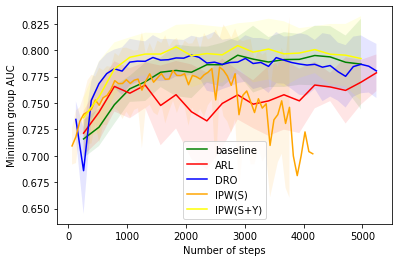

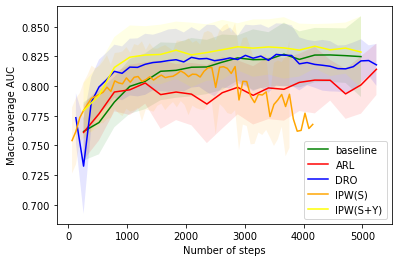

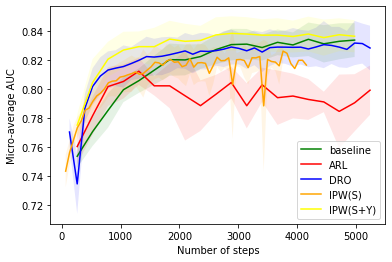

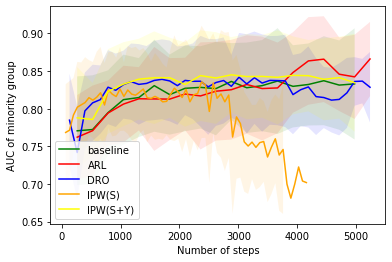

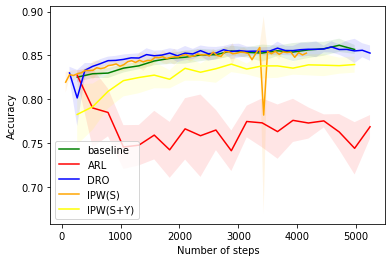

In [5]:
plot_args.models = ['baseline', 'DRO', 'ARL']
for metric in metrics:
    plot_args.metric = metric
    plot.main(plot_args)
    plt.show()

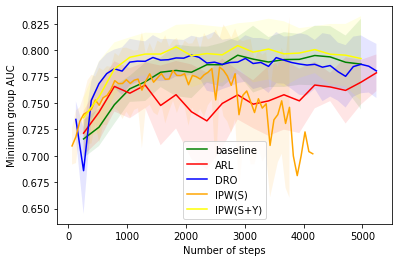

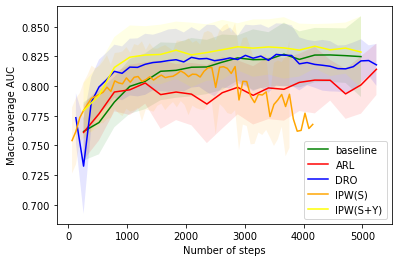

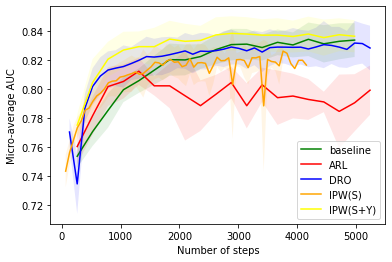

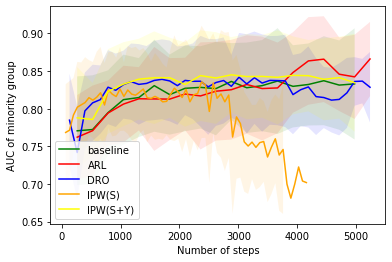

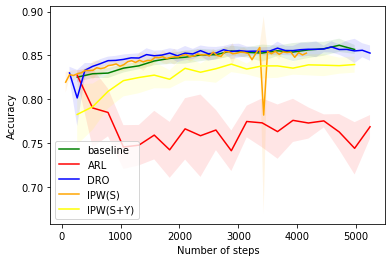

In [5]:
plot_args.models = ['ARL', 'IPW(S)', 'IPW(S+Y)']
for metric in metrics:
    plot_args.metric = metric
    plot.main(plot_args)
    plt.show()

## Computational identifiability with a linear adversary
A fundamental assumption justifying ARL is that the adversary is able to at least partially determine the protected group memberships from the available features.

## Notes on further results


### Grid search
Our `main.py` script can run the entire grid search that we used to determine learning rate and batch size. Simply run `python main.py --model MODEL --dataset DATASET --tf_mode --disable_warnings`. You may also want to set `--num_cpus` and `--num_workers`. Do this for all the models and datasets you want to check. The optimal hyperparameters will be printed and also saved to disk. Then you can enter those in the `optimal_hparams` dictionary above and continue in the section "Runs for all models and datasets" to do several different runs with those hyperparameters and average the results.

### Comparison to Tensorflow implementation (Appendix A)
For our report, we also compared the results we got using our PyTorch implementation to the ones we got when using the authors' Tensorflow implementation (both using the same hyperparameters). Because this requires setting up and running the code published by the authors in addition to the code contained in this repository, we do not include this experiment in this notebook.

To reproduce it, the comparison between our results and those from the paper we did above can be used as a basis. Instead of loading the `their_results` variable from the JSON file with the paper results, you will need to run the authors' implementation (with the same hyperparameters used for `our_results`) and load the results you get this way.

### Runs with 100k steps (Appendix C)
To use 100k steps instead of the default 5k, simply change `args.train_steps` before running the cell that trains all models on all datasets.